In [1]:
!pip install fastkaggle fastai kagglehub

In [1]:
import timm

from fastkaggle import *

comp = 'hack-rush-deep-fake-detection'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

/home/andreas/paddy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

train_path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-dataset")

test_path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-test-dataset")

In [15]:
from fastai.vision.all import *
path.ls()
print(train_path)
print(test_path)
trn_path = Path('mic')
tst_path = Path('mic-test')


/home/andreas/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-dataset/versions/1
/home/andreas/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-test-dataset/versions/2


In [19]:
resize_images(train_path, dest=trn_path, max_size=128, recurse=True, max_workers=7)

/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency

In [20]:
resize_images(test_path, dest=tst_path, max_size=128, recurse=True, max_workers=8)

/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [16]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        learn.export(f"{arch}_{size}_e{epochs}")
        tst_files = get_image_files(tst_path)

        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix()
        interp.plot_top_losses(9)

        test_dl = learn.dls.test_dl(tst_files)
        preds, _ = learn.tta(dl=test_dl)

        submission = pd.DataFrame({
            "filename": [f.name for f in test_dl.items],
            "class": preds.argmax(dim=1).numpy()
        })
        submission.to_csv("submission.csv", index=False)
        return learn
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.416352,0.426515,0.182635,02:19


epoch,train_loss,valid_loss,error_rate,time
0,0.335904,0.397916,0.172572,02:47
1,0.310717,0.360079,0.143214,02:53
2,0.275512,0.374325,0.150116,02:49
3,0.268489,0.343350,0.139305,02:45


/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


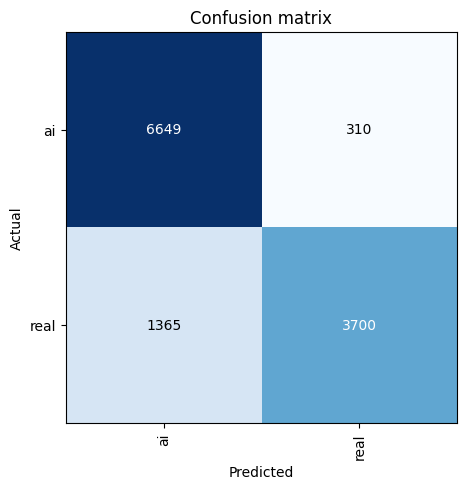

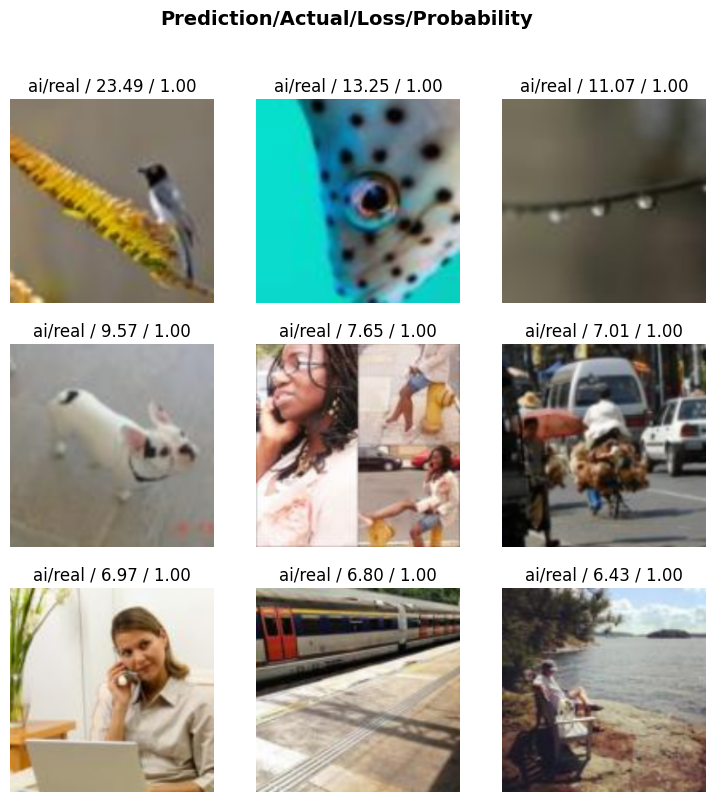

In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()
learn = train('resnet50', 224, item=Resize((128, 128)), accum=1, epochs=4)

In [ ]:
restnet50_result = result


In [12]:
!head submission.csv

filename,class
4403.jpg,0
4222.jpg,0
2158.jpg,0
2257.jpg,0
2688.jpg,1
691.jpg,1
95.jpg,0
1931.jpg,0
2844.jpg,1


In [18]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission.csv', 'resnet50 128 4e', comp)

100%|██████████| 52.6k/52.6k [00:01<00:00, 32.2kB/s]


In [ ]:
models_paths = ["resnet50_224_e4"]#["convnext_small_in22k_128x128_244_e4.pkl", "resnet50_224_e4", "vit_small_patch16_224_128x128_224_e4.pkl"]
models = [load_learner(path, cpu=False) for path in models_paths]

tst_files = get_image_files(tst_path)

predictions = []

for model in models:
    test_dl = model.dls.test_dl(tst_files)
    preds, _ = model.tta(dl=test_dl)
    predictions.append(preds)


/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(a

In [33]:
preds = np.array(predictions)
print(preds.shape)
preds = np.mean(preds, axis=0)
print(preds.shape)

submission = pd.DataFrame({
    "filename": [f.name for f in test_dl.items],
    "class": np.argmax(preds, axis=1)
})
submission.to_csv("submission-ensemble.csv", index=False)

(1, 5000, 2)
(5000, 2)


In [34]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission-ensemble.csv', 'ensemble res', comp)

100%|██████████| 52.6k/52.6k [00:00<00:00, 55.1kB/s]
